In [1]:
#import libraries

import os
import numpy as np
from keras.applications import VGG16
#from keras.models import Sequential
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
# Data preparation
dataset_dir= r'C:\Users\Grace\Desktop\CRC_class\crc_skin_data'
input_shape=(224, 224, 3)
batch_size=4
num_classes=2

In [4]:
#Data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen=ImageDataGenerator(
    rescale=1./255)

In [5]:
#Generate the train dataset, validation dataset and test dataset
train_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary', #skin has two classes: benign and malignant
    subset='training')

validation_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary', #skin has two classes: benign and malignant
    subset='validation')

test_generator=test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary' #skin has two classes: benign and malignant
)

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
#Ensemble Model

# Define the first CNN network
def create_model1(input_shape):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    flatten1 = Flatten()(pool1)
    dense1 = Dense(128, activation='relu')(flatten1)
    model = Model(inputs=inputs, outputs=dense1)
    return model

# Define the second CNN network
def create_model2(input_shape):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(64, (3, 3), activation='relu')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    flatten1 = Flatten()(pool1)
    dense1 = Dense(256, activation='relu')(flatten1)
    model = Model(inputs=inputs, outputs=dense1)
    return model

# Combine the two models into an ensemble model
def create_ensemble_model(input_shape):
    input_layer = Input(shape=input_shape)
    model1 = create_model1(input_shape)(input_layer)
    model2 = create_model2(input_shape)(input_layer)
    merged = concatenate([model1, model2])
    dense = Dense(256, activation='relu')(merged)
    output_layer = Dense(num_classes, activation='sigmoid')(dense)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 1 #benign and malignant

# Create the ensemble model
ensemble_model = create_ensemble_model(input_shape)

In [7]:
ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128)          50467840    ['input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 256)          201869312   ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 384)          0           ['model[0][0]',            

In [8]:
# Compile and train the ensemble model
ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [9]:
#Train the model
history=ensemble_model.fit(train_generator, epochs=5, validation_data=(validation_generator), verbose=1)

Epoch 1/5
100/100 [==============================] - 43s 321ms/step - loss: 2.4820 - accuracy: 0.5825 - val_loss: 0.7015 - val_accuracy: 0.5000
Epoch 2/5
100/100 [==============================] - 31s 313ms/step - loss: 0.6306 - accuracy: 0.6900 - val_loss: 0.5414 - val_accuracy: 0.6900
Epoch 3/5
100/100 [==============================] - 31s 312ms/step - loss: 0.4909 - accuracy: 0.7450 - val_loss: 0.5812 - val_accuracy: 0.6500
Epoch 4/5
100/100 [==============================] - 31s 313ms/step - loss: 0.5204 - accuracy: 0.7525 - val_loss: 0.5891 - val_accuracy: 0.6500
Epoch 5/5
100/100 [==============================] - 31s 313ms/step - loss: 0.4784 - accuracy: 0.7550 - val_loss: 0.5143 - val_accuracy: 0.7300


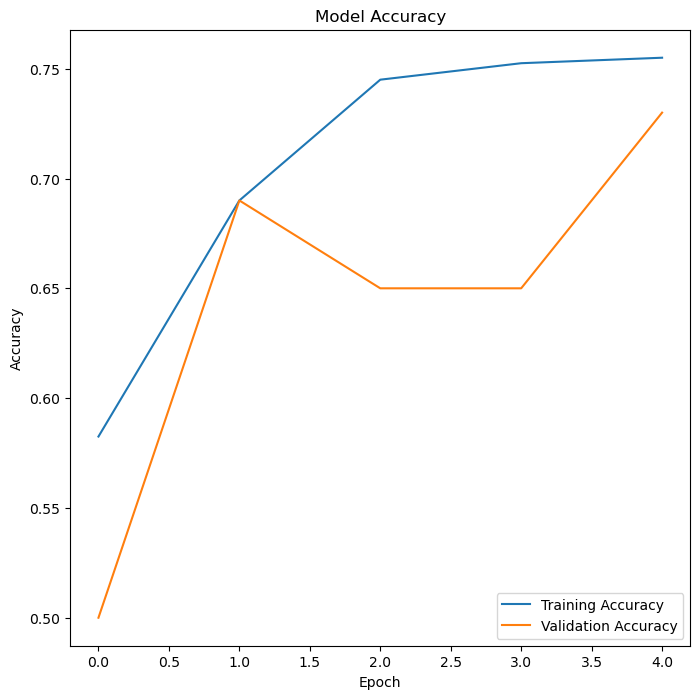

In [10]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')
plt.show()

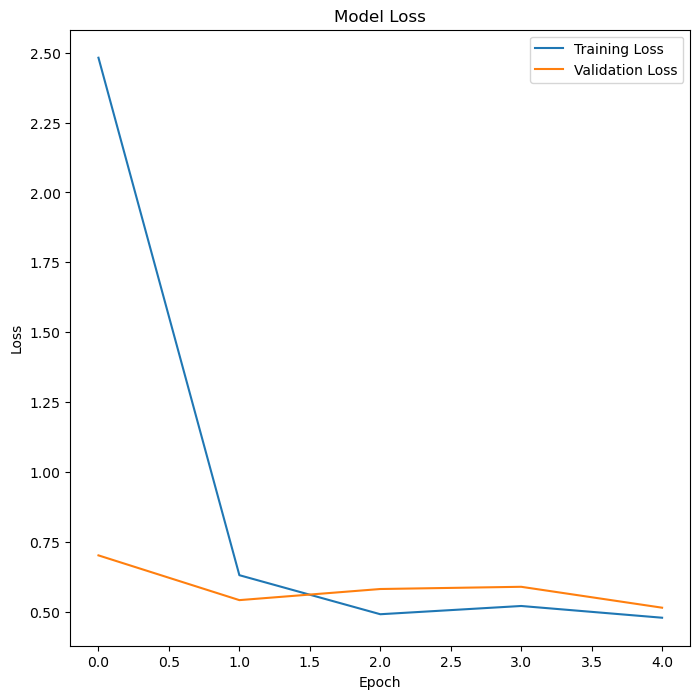

In [11]:
#Trainig loss and validation loss graph
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')
plt.show()

In [13]:
# Evaluate the model on the testing dataset
test_loss, test_acc = ensemble_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

25/25 [==============================] - 1s 51ms/step - loss: 0.4752 - accuracy: 0.8400
Test loss: 0.47521722316741943
Test accuracy: 0.8399999737739563


In [14]:
#Compute confusion matrix
from sklearn.metrics import confusion_matrix

#Generate predictions for the test dataset
y_pred=ensemble_model.predict(test_generator)
y_pred_labels= (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

#compute the confusion matrix
confusion= confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:")
print(confusion)

25/25 [==============================] - 1s 48ms/step
Confusion Matrix:
[[15 35]
 [21 29]]


In [15]:
#compute f1-score
from sklearn.metrics import f1_score

f1=f1_score(y_true, y_pred_labels)
print('F1-score:', f1)

F1-score: 0.5087719298245614


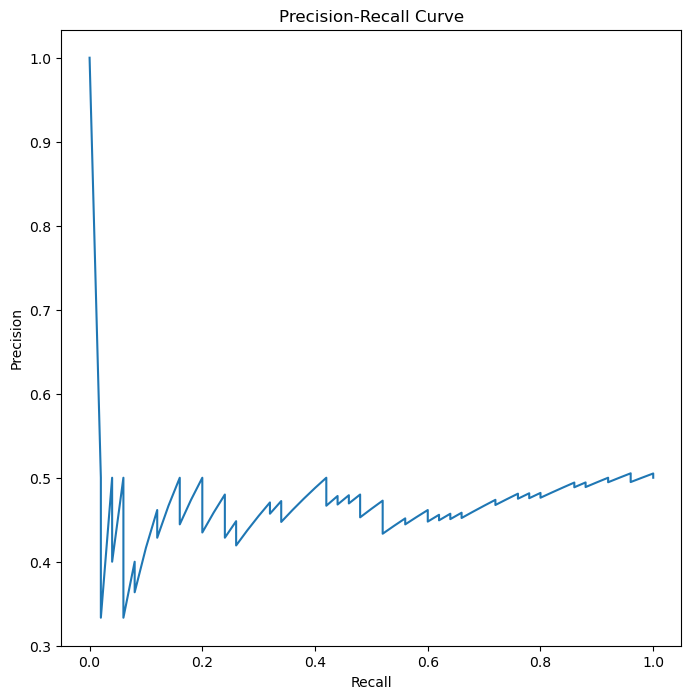

In [16]:
#compute precision-recall score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#compute precision, recall(sensitivity), and threshold values
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

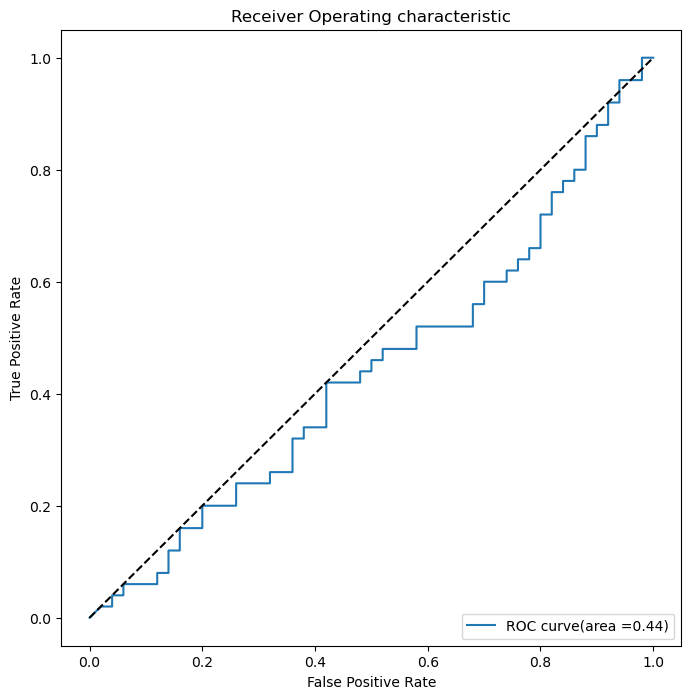

In [17]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [18]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.02
specificity: 0.98


In [20]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del ensemble_model



In [21]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()